In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple application of ft-fsd-path-planning

This notebook shows how to use the ft-fsd-path-planning package to calculate a centerline
given the car's position and direction as well as the cone positions (and optionally the colors)

## Data generation

We will generate a simple track with a constant curvature and a few cones.

In [36]:
import numpy as np
from fsd_path_planning.utils.math_utils import unit_2d_vector_from_angle, rotate
from fsd_path_planning.utils.cone_types import ConeTypes

In [37]:
phi_inner = np.arange(0, np.pi / 2, np.pi / 15)
phi_outer = np.arange(0, np.pi / 2, np.pi / 20)

points_inner = unit_2d_vector_from_angle(phi_inner) * 9
points_outer = unit_2d_vector_from_angle(phi_outer) * 12

center = np.mean((points_inner[:2] + points_outer[:2]) / 2, axis=0)
points_inner -= center
points_outer -= center

rotated_points_inner = rotate(points_inner, -np.pi / 2)
rotated_points_outer = rotate(points_outer, -np.pi / 2)
cones_left_raw = rotated_points_inner
cones_right_raw = rotated_points_outer

car_position = np.array([0.0, 0.0])
car_direction = np.array([1.0, 0.0])

## Color information

The algorithm can work without knowing the colors of the cones. However, if the colors are known, the algorithm can use them to improve the result. In the following cell we will overwrite the color information of the cones. If you want to keep the color information comment out the relevant lines in the following cell.

In [51]:
mask_is_left = np.ones(len(cones_left_raw), dtype=bool)
mask_is_right = np.ones(len(cones_right_raw), dtype=bool)

# for demonstration purposes, we will set all the cones to be unknown
# comment out the next two lines to keep the color information
# mask_is_left[:] = False
# mask_is_right[:] = False

cones_left = cones_left_raw[mask_is_left]
cones_right = cones_right_raw[mask_is_right]
cones_unknown = np.row_stack([cones_left_raw[~mask_is_left], cones_right_raw[~mask_is_right]])

## Visualization

The following cell visualizes the track and the cones. The cones are colored according to their color information. If a cone has no color information, it is colored black.

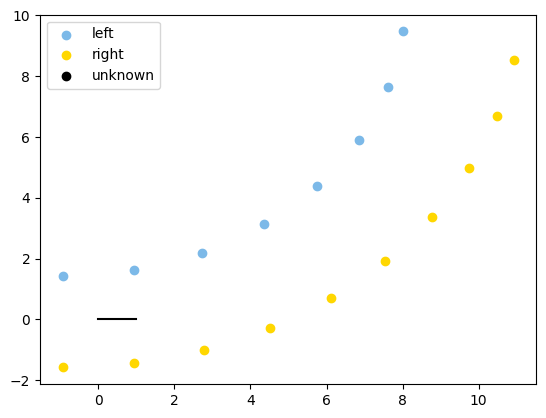

In [52]:
import matplotlib.pyplot as plt

blue_color = "#7CB9E8"
yellow_color = "gold"

plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")
plt.legend()
plt.plot([car_position[0], car_position[0] + car_direction[0]], [car_position[1], car_position[1] + car_direction[1]], c="k")

## Path planning

The following cells show how to use the `PathPlanner` class. 

First we import the class as well as the mission and cone type enums.

In [53]:
from fsd_path_planning import PathPlanner, MissionTypes, ConeTypes

Now we create an instance of the `PathPlanner` class. The constuctor takes the mission type as an argument.

In [54]:
planner = PathPlanner(MissionTypes.trackdrive)

We will now setup the inputs for the actual path calculation.

The cones are given to the path planner as a list of 2D numpy arrays. The list contains five arrays, each representing cones of different colors. See the `ConeTypes` class to see the actual indices of the different cone colors.

In [55]:
for c in ConeTypes:
    print(c)

cones_by_type = [np.zeros((0, 2)) for _ in range(5)]
cones_by_type[ConeTypes.LEFT] = cones_left
cones_by_type[ConeTypes.RIGHT] = cones_right
cones_by_type[ConeTypes.UNKNOWN] = cones_unknown

ConeTypes.UNKNOWN
ConeTypes.YELLOW
ConeTypes.BLUE
ConeTypes.ORANGE_SMALL
ConeTypes.ORANGE_BIG


We are now ready to calculate the path. The `calculate_path_in_global_frame` function receives the car's position and direction as well as the list of 2D numpy arrays containing the cone positions. It returns a 2D numpy array containing the centerline points. The function can optionally return the intermediate results of the algorithm. This is useful for debugging and visualization, which we will do in the following cells.

In [56]:
out = planner.calculate_path_in_global_frame(cones_by_type, car_position, car_direction, return_intermediate_results=True)

(path,
sorted_left,
sorted_right,
left_cones_with_virtual,
right_cones_with_virtual,
left_to_right_match,
right_to_left_match) = out

In [57]:
# you can uncomment the following line to get an approximate speed profile
# %timeit planner.calculate_path_in_global_frame(cones_by_type, car_position, car_direction)

## Results

We can now visualize the calculated path. The path is extrapolated/trimmed so that it has a specified length.

In the next cell we will visualize the intermediate results of the algorithm. The intermediate results are returned by the `calculate_path_in_global_frame` function if the `return_intermediate_results` argument is set to `True`.

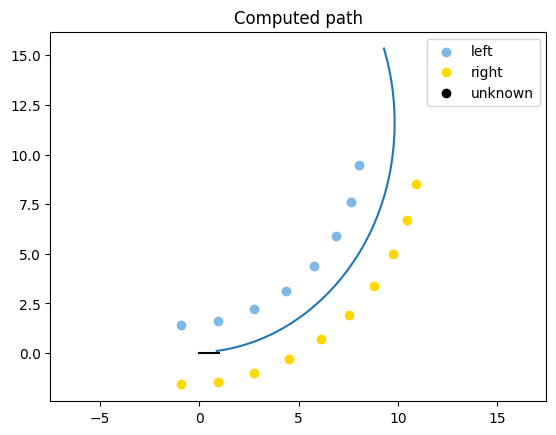

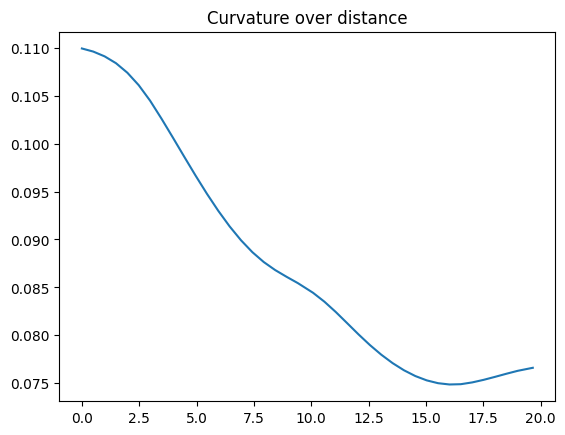

In [58]:
plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")

plt.legend()

plt.plot([car_position[0], car_position[0] + car_direction[0]], [car_position[1], car_position[1] + car_direction[1]], c="k")
plt.title('Computed path')
plt.plot(*path[:,1:3].T)

plt.axis("equal")

plt.show()

plt.title('Curvature over distance')
plt.plot(path[:, 0], path[:, 3]);

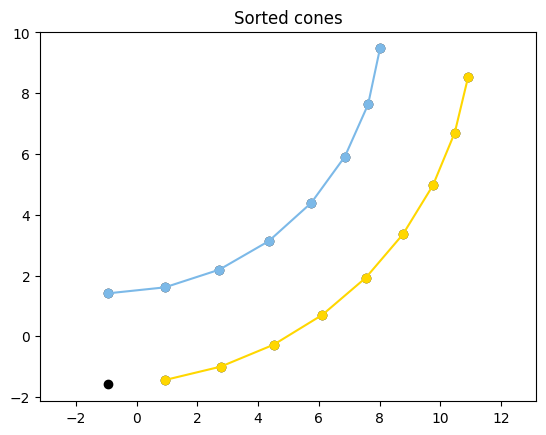

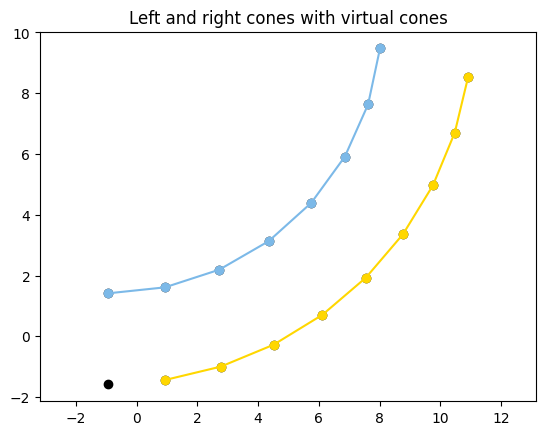

(-1.5297177038177339,
 11.507768392038084,
 -2.13906506809308,
 10.026103145557148)

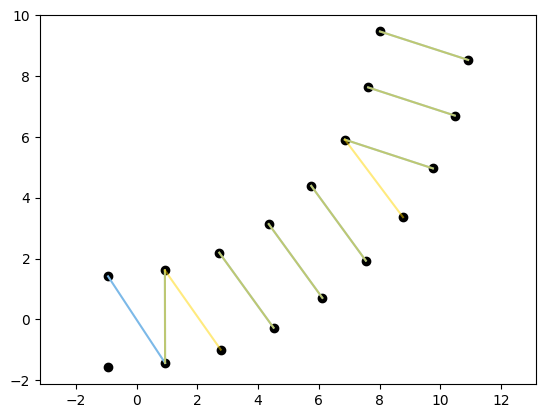

In [59]:
all_cones = np.row_stack([cones_left, cones_right, cones_unknown])


plt.plot(*all_cones.T, 'o', c="k")
plt.plot(*sorted_left.T, 'o-', c=blue_color)
plt.plot(*sorted_right.T, 'o-', c=yellow_color)
plt.title('Sorted cones')
plt.axis("equal")
plt.show()


plt.plot(*all_cones.T, 'o', c="k")
plt.plot(*left_cones_with_virtual.T, 'o-', c=blue_color)
plt.plot(*right_cones_with_virtual.T, 'o-', c=yellow_color)
plt.title('Left and right cones with virtual cones')
plt.axis("equal")
plt.show()

plt.plot(*all_cones.T, 'o', c="k")



for left, right_idx in zip(left_cones_with_virtual, left_to_right_match):
    plt.plot([left[0], right_cones_with_virtual[right_idx][0]], [left[1], right_cones_with_virtual[right_idx][1]], '-', c=blue_color)


for right, left_idx in zip(right_cones_with_virtual, right_to_left_match):
    plt.plot([right[0], left_cones_with_virtual[left_idx][0]], [right[1], left_cones_with_virtual[left_idx][1]], '-', c=yellow_color, alpha=0.5)

plt.axis("equal")